In [ ]:
from google.colab import data_table, drive
import os

data_table.enable_dataframe_formatter()
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/Colab Notebooks/DSC 245 - Intro to Causal Inference"

Mounted at /content/drive/


## This notebook creates node embeddings by DeepWalk and Node2Vec

In [ ]:
!pip install --upgrade gensim
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", whi

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import pandas as pd
import numpy as np
import gensim

import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from node2vec import Node2Vec
from tqdm import tqdm
import random

In [ ]:
# Shuffle the DataFrame
multi_data=pd.read_csv(os.path.join(data_path,"criteo-uplift-v2.1.csv"))
multi_data.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'T', 'y', 'visit', 'tau']
df_shuffled = multi_data.sample(frac=1, random_state=2022).reset_index(drop=True)

# Calculate the number of samples for train_val set
train_val_size = int(len(df_shuffled) * 0.2)
train_val_set = df_shuffled.iloc[:train_val_size]

# Calculate the number of samples for the training set within the train_val set
train_size_within_train_val = int(train_val_size * 0.8)

# Split train_val set into train and validation sets
train_set = train_val_set.iloc[:train_size_within_train_val]
val_set = train_val_set.iloc[train_size_within_train_val:]

In [ ]:
multi_data.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'T', 'y', 'visit', 'tau'],
      dtype='object')

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
#df=pd.read_csv(io.BytesIO(uploaded['criteo_train.csv']),index_col=0)
# df=pd.read_csv('criteo_train.csv',index_col=0)
df=train_set
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,T,y,visit,tau
0,24.525153,10.059654,8.977959,4.679882,10.280525,4.115453,-2.411115,4.833815,3.920995,13.190056,5.300375,-0.168679,0,0,0,0
1,14.456602,10.679513,8.233941,3.359763,11.029584,3.013064,-4.595460,8.178492,3.761022,39.022417,6.116006,-0.168679,1,0,1,0
2,19.818905,10.059654,9.026540,3.359763,10.280525,4.115453,-7.301017,4.833815,3.927254,13.190056,5.300375,-0.168679,1,0,0,0
3,25.673412,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
4,22.580405,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236729,12.616365,10.059654,8.353754,4.679882,10.280525,4.115453,0.294443,4.833815,3.803324,34.180688,5.300375,-0.168679,1,0,1,1
2236730,24.398619,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
2236731,24.362248,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
2236732,12.616365,10.059654,9.015187,4.679882,10.280525,4.115453,0.294443,4.833815,3.915574,13.190056,5.300375,-0.168679,1,0,0,0


In [ ]:
col=df.columns
y=torch.from_numpy((np.array(df['y']))).reshape(df.shape[0],1).to(torch.float32)
x=torch.from_numpy(np.array(df[[c for c in df.columns[:-4]]+["visit"]+["T"]])).to(torch.float32)
x=x[0].reshape(-1,1)
y=y[0].reshape(-1,1)

# load edge index
edge_index=pd.read_csv(os.path.join(data_path,'criteo_edge_index.csv'))
edge_index=torch.from_numpy(np.transpose(np.array(edge_index)))

data=Data(x=x,edge_index=edge_index,y=y)

In [ ]:
random_walks = []
def get_randomwalk(node, path_length):

    random_walk = [node]
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node

    return random_walk

G=to_networkx(data)
all_nodes=list(G.nodes())

for n in tqdm(all_nodes):
    for i in range(20):
        random_walks.append(get_randomwalk(n,50))

100%|██████████| 15/15 [00:00<00:00, 1838.75it/s]


In [ ]:
df[[c for c in df.columns[:-4]]+["visit"]+["T"]]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,visit,T
0,24.525153,10.059654,8.977959,4.679882,10.280525,4.115453,-2.411115,4.833815,3.920995,13.190056,5.300375,-0.168679,0,0
1,14.456602,10.679513,8.233941,3.359763,11.029584,3.013064,-4.595460,8.178492,3.761022,39.022417,6.116006,-0.168679,1,1
2,19.818905,10.059654,9.026540,3.359763,10.280525,4.115453,-7.301017,4.833815,3.927254,13.190056,5.300375,-0.168679,0,1
3,25.673412,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0
4,22.580405,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236729,12.616365,10.059654,8.353754,4.679882,10.280525,4.115453,0.294443,4.833815,3.803324,34.180688,5.300375,-0.168679,1,1
2236730,24.398619,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,0,1
2236731,24.362248,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0
2236732,12.616365,10.059654,9.015187,4.679882,10.280525,4.115453,0.294443,4.833815,3.915574,13.190056,5.300375,-0.168679,0,1


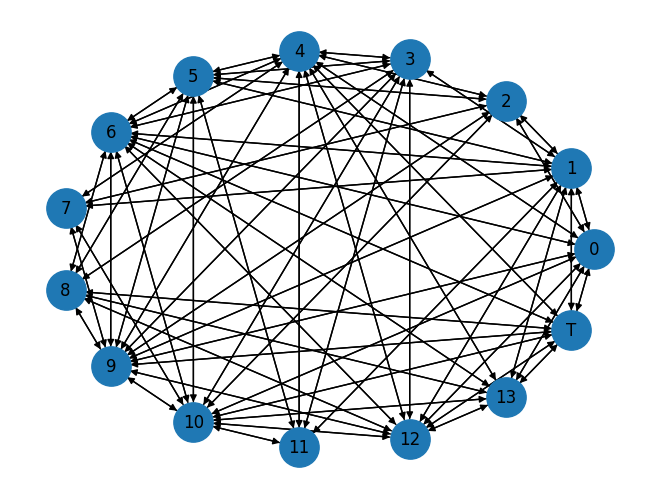

In [12]:
def draw(Data):
    G = to_networkx(Data)
    mapping = {14:'T' }
    relabeled_G = nx.relabel_nodes(G,mapping)
    nx.draw_circular(relabeled_G,node_size=800,with_labels=True)
    plt.savefig("path.png")
    plt.show()
draw(data)

## Node embeddings generated from Deepwalk

In [15]:
model = Word2Vec(vector_size=10,window = 4, sg = 1, hs = 0,
                 negative = 3, alpha=0.03, min_alpha=0.0007,seed = 14)
model.build_vocab(random_walks, progress_per=5)
model.train(random_walks,total_examples = model.corpus_count, epochs=30, report_delay=1)
model.save(os.path.join(data_path,"deepwalk_10d_x13.model"))
#files.download("deepwalk_10d_x13.model")
model.wv.similar_by_word(1)

[(2, 0.9294850826263428),
 (11, 0.8785176277160645),
 (4, 0.8603787422180176),
 (10, 0.8601088523864746),
 (3, 0.8555288910865784),
 (12, 0.841693639755249),
 (0, 0.8373467326164246),
 (7, 0.8243615031242371),
 (13, 0.8221889734268188),
 (6, 0.8200652599334717)]

## Node embeddings generated from Node2Vec

In [14]:
import gensim
import node2vec
node2vec = Node2Vec(graph=G, dimensions=10, walk_length=50, num_walks=100, workers=4)  # Use temp_folder for big graphs
model = node2vec.fit(window=4, min_count=1, batch_words=4)
model.save(os.path.join(data_path,"Node2Vec_10d_x13.model"))
#files.download("Node2Vec_10d_x13.model")
model.wv.similar_by_word(1)

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

[('4', 0.9802151918411255),
 ('10', 0.964518666267395),
 ('9', 0.9203532934188843),
 ('0', 0.8710377216339111),
 ('2', 0.8606436848640442),
 ('6', 0.8493420481681824),
 ('8', 0.828021228313446),
 ('3', 0.8270009756088257),
 ('5', 0.8127085566520691),
 ('11', 0.8102972507476807)]

In [ ]:
from sklearn.manifold import TSNE
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# node_targets = subjects.loc[node_ids].astype("category")

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    # c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

sim = pd.DataFrame(cosine_similarity(model.wv.vectors))
column_names = [c for c in df.columns[:-4]]+["visit","T",'y']
# column_names.remove('tau')
sim.columns = column_names
sim.index = column_names
sim.style.background_gradient(cmap='viridis')

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,visit,T,y
f0,1.000000,0.916591,0.860379,0.828332,0.896705,0.778628,0.722125,0.892613,0.909996,0.787473,0.804532,0.775151,0.831148,0.952501,0.760958
f1,0.916591,1.000000,0.860109,0.876693,0.914658,0.804741,0.866889,0.859508,0.769828,0.886638,0.842067,0.797665,0.732875,0.873218,0.864223
f2,0.860379,0.860109,1.000000,0.803938,0.841694,0.794087,0.820065,0.855529,0.817519,0.837347,0.822189,0.929485,0.796265,0.824361,0.878518
f3,0.828332,0.876693,0.803938,1.000000,0.914650,0.879836,0.862237,0.819491,0.818270,0.935580,0.934114,0.813985,0.860484,0.903932,0.797223
f4,0.896705,0.914658,0.841694,0.914650,1.000000,0.845975,0.855691,0.962311,0.893565,0.919809,0.854382,0.889724,0.847728,0.881278,0.882551
f5,0.778628,0.804741,0.794087,0.879836,0.845975,1.000000,0.710744,0.717952,0.762912,0.827717,0.885934,0.821698,0.860499,0.822910,0.692143
f6,0.722125,0.866889,0.820065,0.862237,0.855691,0.710744,1.000000,0.815746,0.625328,0.957154,0.788229,0.823016,0.678647,0.732363,0.889576
f7,0.892613,0.859508,0.855529,0.819491,0.962311,0.717952,0.815746,1.000000,0.916802,0.866302,0.780150,0.885131,0.803358,0.844562,0.902126
f8,0.909996,0.769828,0.817519,0.818270,0.893565,0.762912,0.625328,0.916802,1.000000,0.756076,0.806760,0.812906,0.883621,0.908955,0.757282
f9,0.787473,0.886638,0.837347,0.935580,0.919809,0.827717,0.957154,0.866302,0.756076,1.000000,0.903182,0.856550,0.807435,0.836506,0.913755
